In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modules.Utils.utils import loadFromDB, strategyTester

In [2]:
SYMBOL= 'BTC'
df = loadFromDB(SYMBOL,'1d')
df = df.interpolate()
print(df.shape)

train = df[:df.shape[0]//2]
test = df[df.shape[0]//2:]
df.head()

(876, 6)


,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2020-06-01,9448.27,10380.00,9421.67,10200.77,76649.126960,1590969600
2020-06-02,10202.71,10228.99,9266.00,9518.04,108970.773151,1591056000
2020-06-03,9518.02,9690.00,9365.21,9666.24,46252.644939,1591142400
2020-06-04,9666.32,9881.63,9450.00,9789.06,57456.100969,1591228800
2020-06-05,9788.14,9854.75,9581.00,9621.16,47788.050050,1591315200


In [3]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel


def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['Close'][:i].iloc[-window:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'theta':
        pred_theta = []
        
        for i in range(train_len, total_len, window):
            tm = ThetaModel(endog=df['Close'][:i], period=52)
            res = tm.fit()
            predictions = res.forecast(window)
            pred_theta.extend(predictions)
            
        #print(res.summary())

        return pred_theta
              
    elif method == 'tes':
        pred_tes = []
        
        for i in range(train_len, total_len, window):
            tes = ExponentialSmoothing(
                df['Close'][:i],
                trend='add',
                seasonal='add',
                seasonal_periods=52,
                initialization_method='estimated'
            ).fit()
            
            predictions = tes.forecast(window)
            pred_tes.extend(predictions)

    return pred_tes

In [4]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 50

pred_last_season = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')[:len(test)]
pred_theta = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'theta')[:len(test)]
pred_tes = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'tes')[:len(test)]

test = test.copy()

test['pred_last_season'] = pred_last_season# [:-(len(pred_last_season)-len(test))]
test['pred_theta'] = pred_theta# [:-(len(pred_theta)-len(test))]
test['pred_tes'] = pred_tes# [:-(len(pred_tes)-len(test))]

test.head()

/home/baptiste/myworkdir/trading-sandbox/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/baptiste/myworkdir/trading-sandbox/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/baptiste/myworkdir/trading-sandbox/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/baptiste/myworkdir/trading-sandbox/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/baptiste/myworkdir/trading-sandbox/.venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. C

,Open,High,Low,Close,Volume,Timestamp,pred_last_season,pred_theta,pred_tes
Date,,,,,,,,,
2021-08-13,44400.06,47886.00,44217.39,47800.00,48239.370431,1628812800,34663.09,44145.309790,43880.580343
2021-08-14,47799.99,48144.00,45971.03,47068.51,46114.359022,1628899200,31584.45,44426.185055,43890.461893
2021-08-15,47068.50,47372.27,45500.00,46973.82,42110.711334,1628985600,32283.65,44660.286685,43716.412029
2021-08-16,46973.82,48053.83,45660.00,45901.29,52480.574014,1629072000,34700.34,44423.876657,43717.245632
2021-08-17,45901.30,47160.00,44376.00,44695.95,57039.341629,1629158400,34494.89,44049.909928,43999.272442


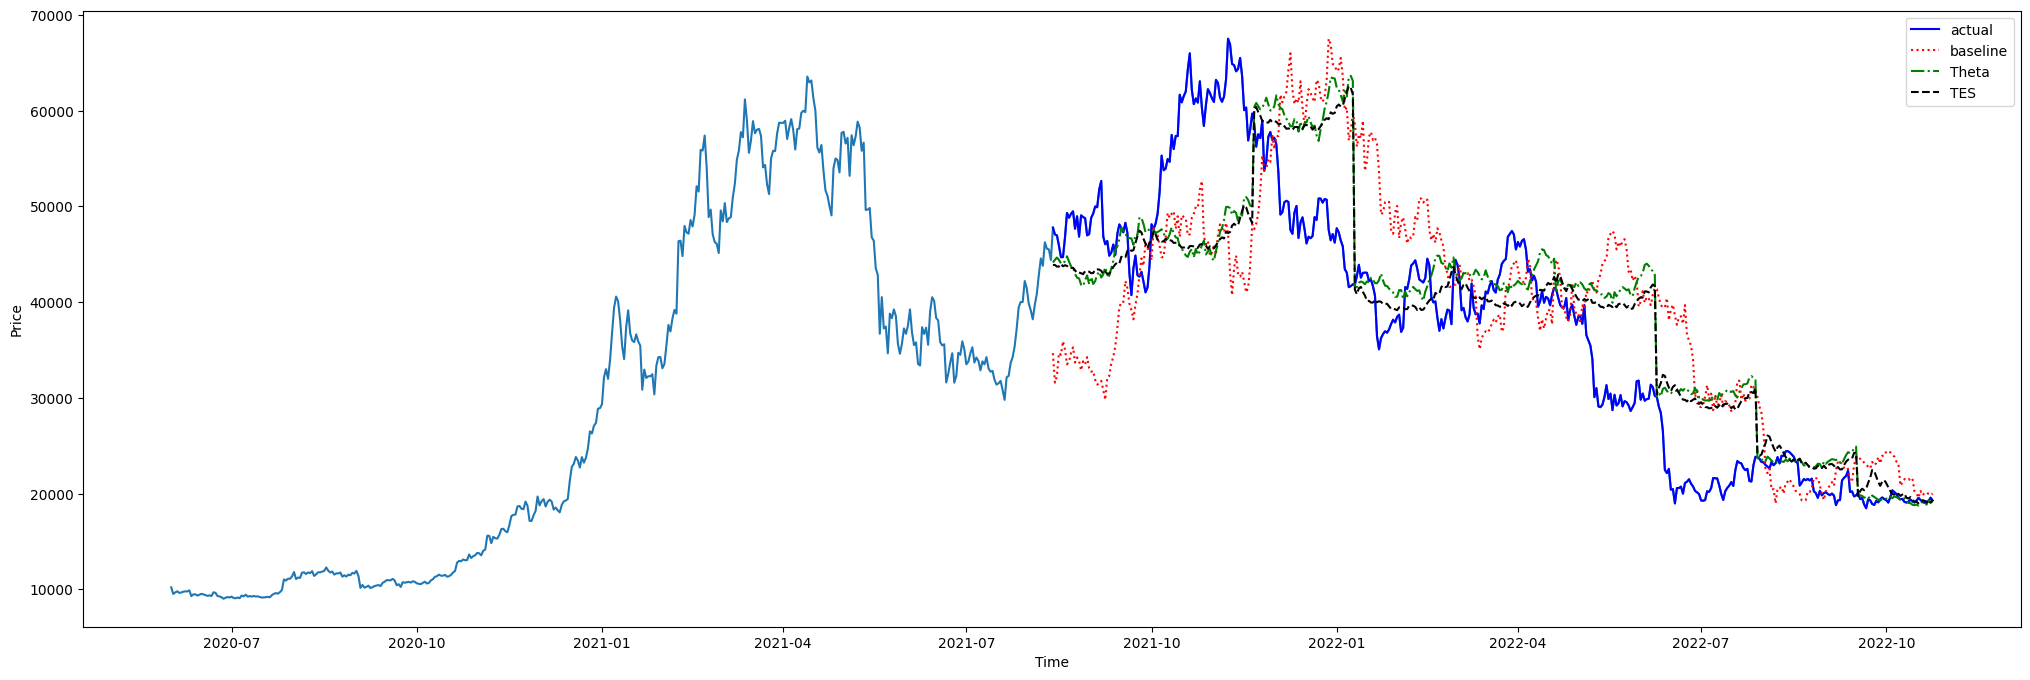

In [5]:
fig, ax = plt.subplots(figsize=(25,8))

ax.plot(df['Close'])
ax.plot(test['Close'], 'b-', label='actual')
ax.plot(test['pred_last_season'], 'r:', label='baseline')
ax.plot(test['pred_theta'], 'g-.', label='Theta')
ax.plot(test['pred_tes'], 'k--', label='TES')

ax.set_xlabel('Time')
ax.set_ylabel('Price')

ax.legend(loc='best')
